In [101]:
import pandas as pd
from utils import pca_utils, utils, pca_utils, plots
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [122]:
df_props = pd.read_csv("./output/df_props.csv")

df_authors = pd.read_csv("./output/df_authors.csv")
df_authors["id_dep"] = df_authors["uri"].apply(lambda x: str(x).split("/")[-1])

df_topics_raw = pd.read_csv("./output/df_topics.csv")
df_topics = df_topics_raw.join(pd.get_dummies(df_topics_raw["tema"]))
df_topics = df_topics.loc[:, "id_prop":]

df_authors_topic = (
    df_authors[["id_prop", "id_dep"]]
    .merge(df_topics)
    .loc[:, "id_dep":]
    .groupby("id_dep")
    .sum()
    .reset_index()
)

df_authors_topic.set_index("id_dep", inplace=True)
df_authors_topic = df_authors_topic.iloc[:-1,:] # remove nan idenx

# temas

In [134]:
def calculate_theil_entropy(row):
    total = row.sum()  # Total of values in the row
    mean = total / len(row)  # Mean value in the row
    n = len(row)

    entropy = 0
    for r in row:
        if r and r > 0:  # Avoid division by zero
            share = r / total
            entropy += share * np.log(1 / share)

    return 1 - (1 / np.log(n)) * entropy  # Normalize by number of elements


df_authors_topic["theil"] = [
    calculate_theil_entropy(row) for _, row in df_authors_topic.iterrows()
]

C:\Users\caca_\AppData\Local\Temp\ipykernel_2712\429460161.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_authors_topic["theil"] = [


<Axes: ylabel='Frequency'>

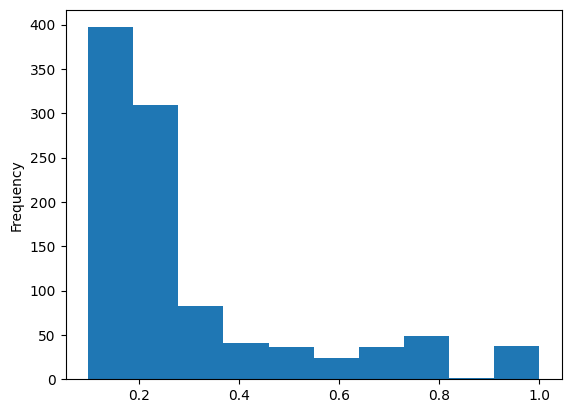

In [135]:
df_authors_topic['theil'].plot(kind='hist')

# atividade

In [136]:
def normalize_minmax(column):
    min_val = column.min()
    max_val = column.max()
    return (column - min_val) / (max_val - min_val)

<Axes: ylabel='Frequency'>

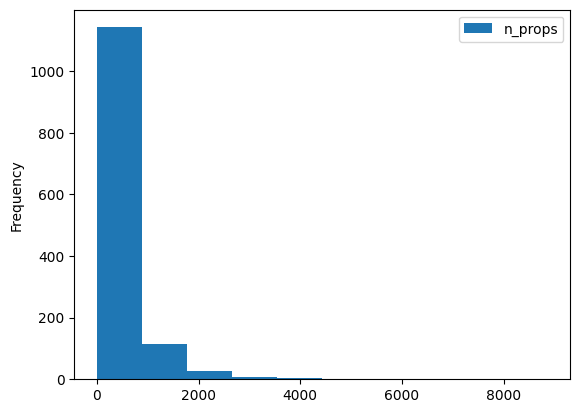

In [138]:
df_activity = (
    df_authors[["id_prop", "id_dep"]]
    .groupby("id_dep")
    .count()
    .rename({"id_prop": "n_props"}, axis=1)
)
# remove nan id
df_activity = df_activity.iloc[:-1,:]

df_activity.plot(kind="hist")

In [181]:
df_activity['norm_freq'] = normalize_minmax(df_activity['n_props'])

df_activity['n_props_log'] = np.log(df_activity['n_props'])
df_activity['norm_props_log'] = normalize_minmax(df_activity['n_props_log'])

In [182]:
df_activity

,n_props,norm_freq,n_props_log,norm_props_log
id_dep,,,,
100011,1,0.000000,0.000000,0.000000
100070,42,0.004623,3.737670,0.411170
100095,2,0.000113,0.693147,0.076251
100177,2,0.000113,0.693147,0.076251
100292,1779,0.200496,7.483807,0.823272
...,...,...,...,...
93083,638,0.071831,6.458338,0.710463
97707,1,0.000000,0.000000,0.000000
98057,1347,0.151782,7.205635,0.792671


# merge

In [183]:
import matplotlib.pyplot as plt

In [184]:
df_merge = df_authors_topic.join(df_activity)

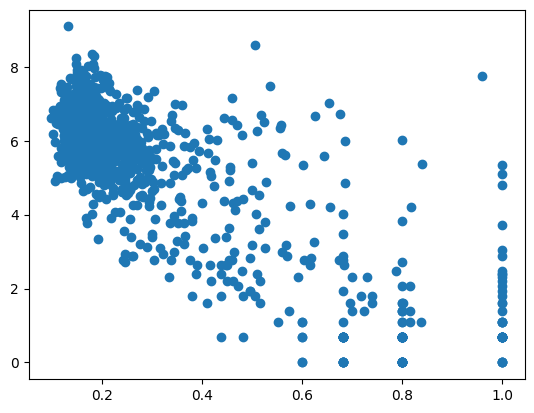

In [188]:
plt.scatter(x=df_merge['theil'], y=df_merge['n_props_log'])
plt.show()

# Cluster

In [151]:
from utils import utils

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture

In [152]:
def cluster_dataframe(
    df,
    techniques=["kmeans", "dbscan", "gmm"],
    k_value=3,
    eps=0.5,
    min_samples=5,
):
    """
    Clusters the input DataFrame using k-means, DBSCAN, and GMM algorithms.

    Args:
        df (pd.DataFrame): The DataFrame to be clustered.
        k_value (int, optional): Number of clusters for k-means. Defaults to 3.
        eps (float, optional): Maximum distance between two samples for DBSCAN. Defaults to 0.5.
        min_samples (int, optional): Minimum number of samples in a neighborhood for DBSCAN. Defaults to 5.

    Returns:
        pd.DataFrame: The original DataFrame with added columns for cluster labels from each algorithm.
    """

    df_c = df.copy()

    # K-means
    if "kmeans" in techniques:
        kmeans = KMeans(n_clusters=k_value, random_state=0).fit(df)
        df_c["k_means_cluster"] = kmeans.labels_

    # DBSCAN
    if "dbscan" in techniques:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(df)
        df_c["dbscan_cluster"] = dbscan.labels_

    # Gaussian Mixture Model (GMM)
    if "gmm" in techniques:
        gmm = GaussianMixture(n_components=k_value, random_state=0).fit(df)
        df_c["gmm_cluster"] = gmm.predict(df)

    return df_c


def melt_df(df, val_columns, cluster_column="Cluster"):
    # Melt the DataFrame
    df_melted = df.reset_index().melt(
        id_vars=["id_dep", cluster_column],  # Keep these as identifier columns
        value_vars=val_columns,
        var_name="var",
        value_name="value",
    )

    df_melted["value"] = df_melted["value"].astype(float)

    return df_melted


def plot_melted_df(df_melted, hue_col="Cluster", figsize=(12, 8), xticks_rotation=45):
    # Set the desired figure size (width, height) in inches
    plt.figure(figsize=figsize)

    # Create the Seaborn boxplot
    sns.boxplot(data=df_melted, x="var", y="value", hue=hue_col)

    # Optional: Adjust layout for better readability (especially with many boxes)
    plt.xticks(rotation=xticks_rotation, ha="right")  # Rotate x-axis labels if needed

    # Show the plot
    plt.tight_layout()
    plt.show()

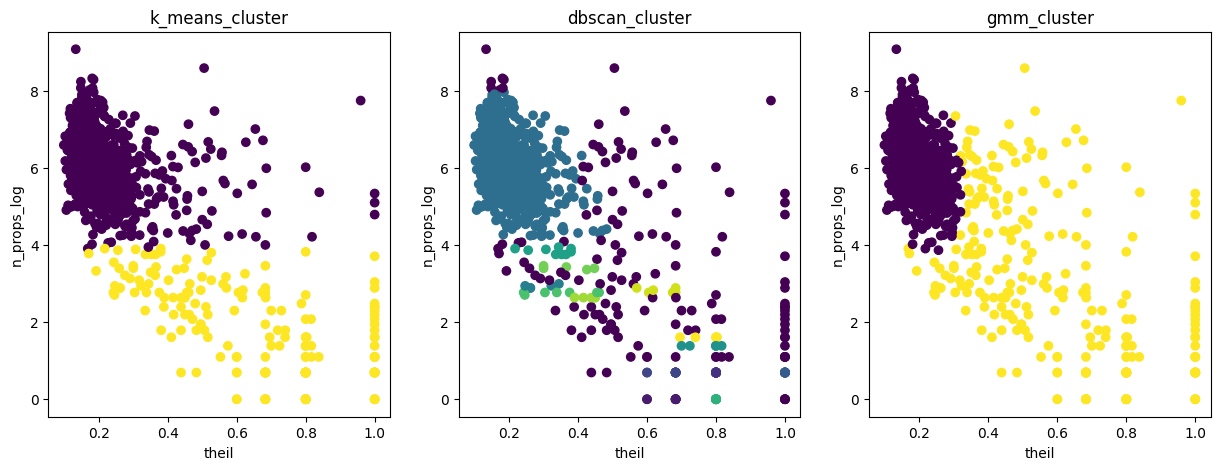

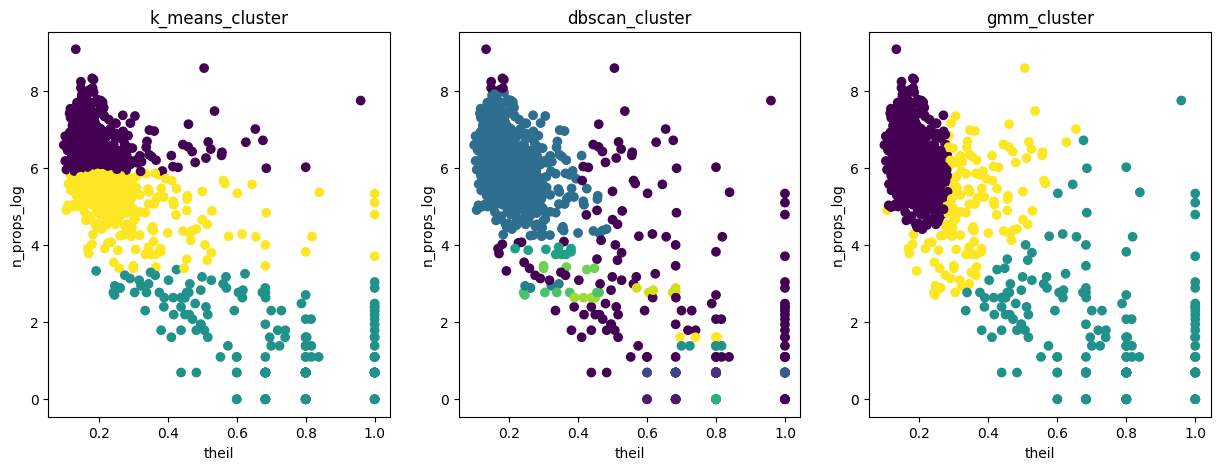

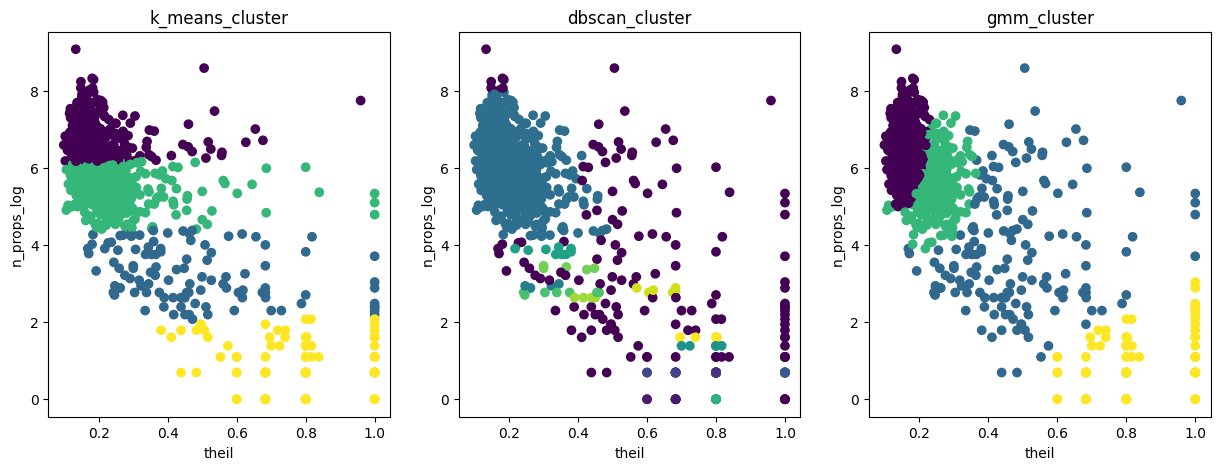

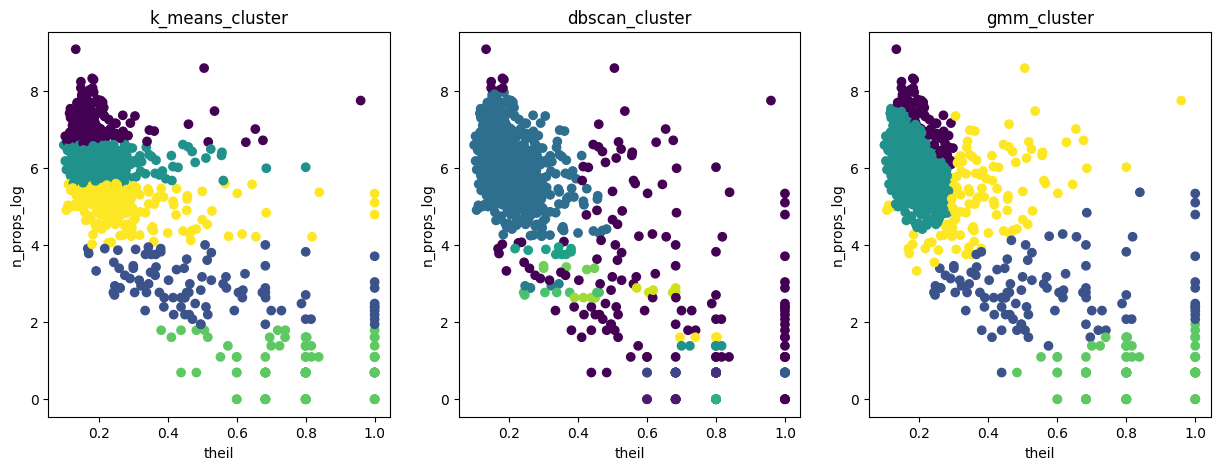

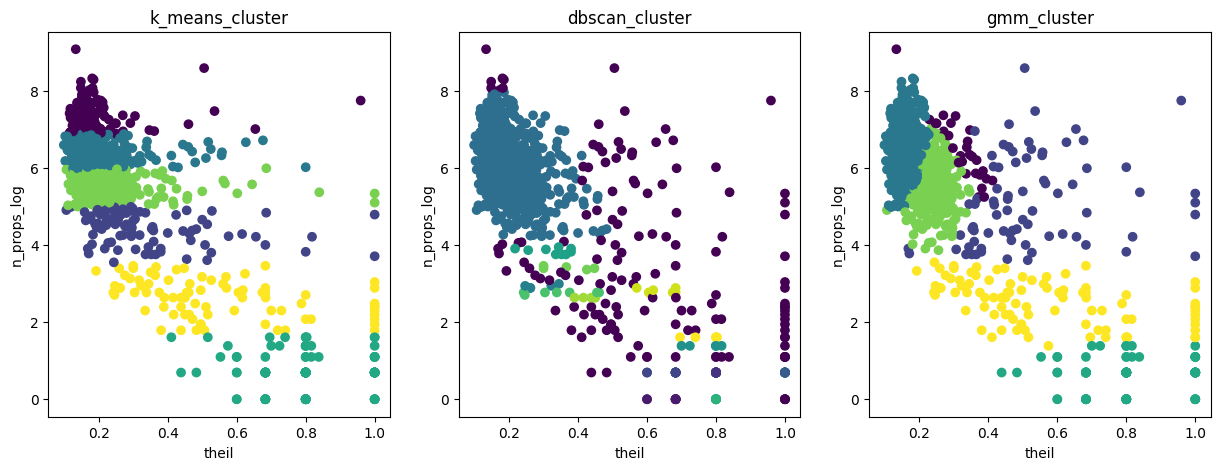

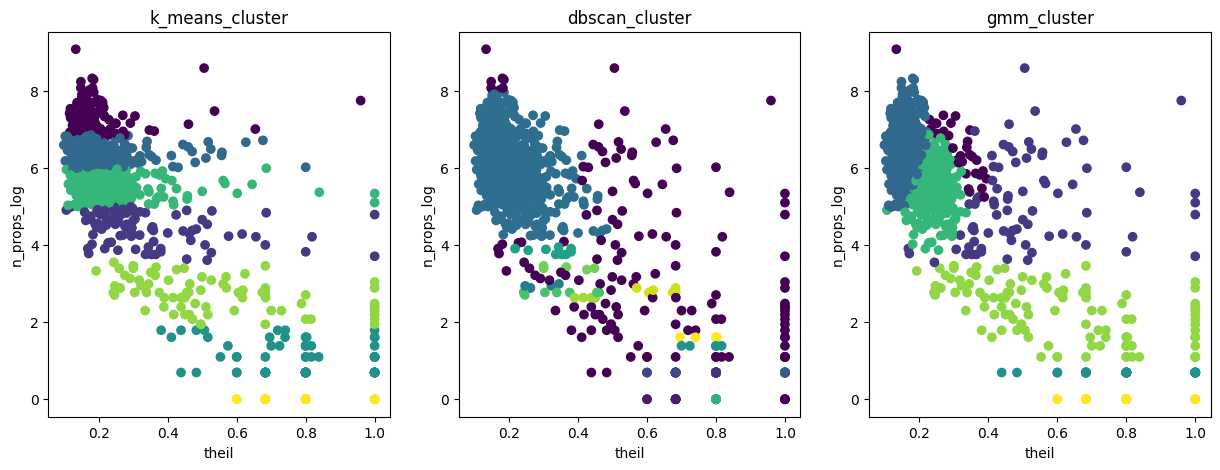

In [197]:
x_label = "theil"
y_label = "n_props_log"
k_value = 4
eps = 0.1
min_samples = 5

for k_value in range (2,8):
    df_cluster = cluster_dataframe(
        df_merge[[x_label, y_label]], k_value=k_value, eps=eps, min_samples=min_samples
    )

    x = df_cluster[x_label]
    y = df_cluster[y_label]


    fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

    # Scatter plot 1
    axs[0].scatter(x=x, y=y, c=df_cluster["k_means_cluster"])
    axs[0].set_title("k_means_cluster")
    axs[0].set_xlabel(x_label)
    axs[0].set_ylabel(y_label)

    # Scatter plot 2
    axs[1].scatter(x=x, y=y, c=df_cluster["dbscan_cluster"])
    axs[1].set_title("dbscan_cluster")
    axs[1].set_xlabel(x_label)
    axs[1].set_ylabel(y_label)

    # Scatter plot 3
    axs[2].scatter(x=x, y=y, c=df_cluster["gmm_cluster"])
    axs[2].set_title("gmm_cluster")
    axs[2].set_xlabel(x_label)
    axs[2].set_ylabel(y_label)
    plt.show()